# Image_Classifier_Project.

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, I train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. I'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

I'll lead you through each part which you'll implement in Python.

The end product of this project is that, you'll have an application that can be trained on any set of labeled images. Here the network will be learning about flowers and end up as a command line application.

## Install Datasets and Upgrade TensorFlow

To ensure we can download the latest version of the `oxford_flowers102` dataset, let's first install both `tensorflow-datasets` and `tfds-nightly`.
* `tensorflow-datasets` is the stable version that is released on a cadence of every few months
* `tfds-nightly` is released every day and has the latest version of the datasets

We'll also upgrade TensorFlow to ensure we have a version that is compatible with the latest version of the dataset.

In [1]:
%pip --no-cache-dir install tensorflow-datasets --user
%pip --no-cache-dir install tfds-nightly --user
%pip --no-cache-dir install --upgrade tensorflow --user

Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 4.5MB 4.5MB/s eta 0:00:01
     |████████████████████████████████| 102kB 36.5MB/s ta 0:00:01
     |████████████████████████████████| 409kB 38.1MB/s eta 0:00:01
ERROR: tensorflow-metadata 0.14.0 has requirement protobuf<4,>=3.7, but you'll have protobuf 4.21.3 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.
     |███████████████████████████████▌| 503.3MB 11.4MB/s eta 0:00:01     |████████████████████████████████| 511.7MB 11.4MB/s eta 0:00:01     |███████████████████████████████▊| 507.3MB 11.4MB/s eta 0:00:01     |████████████████████████████████| 510.6MB 11.4MB/s eta 0:00:01
     |████████████████████████████████| 1.1MB 59.2MB/s eta 0:00:01
     |████████████████████████████████| 1.6MB 45.3MB/s eta 0:00:01
     |█████████████████

In [1]:
#import statements
import numpy as np
import matplotlib.pyplot as plt
import json
import pathlib
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import warnings
warnings.filterwarnings('ignore')
import logging
logger=tf.get_logger()
logger.setLevel(logging.ERROR)
%matplotlib inline
%config InlineBackend.figure_format='retina'
tfds.disable_progress_bar()


After the above installations have finished **be sure to restart the kernel**. You can do this by going to **Kernel > Restart**.

## Load the Dataset

Here I used `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  I also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but I'll still need to normalize and resize the images to the appropriate size.

In [2]:
# TODO: Load the dataset with TensorFlow Datasets. Hint: use tfds.load()
dset,info=tfds.load('oxford_flowers102',with_info=True, as_supervised=True)

#from the tfds.core.DatasetBuilder
builder=tfds.builder('oxford_flowers102')
info=builder.info
print(info)

# TODO: Create a training set, a validation set and a test set.
train_set=dset['train']
validation_set=dset['validation']
test_set=dset['test']

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
    in the United Kingdom. Each class consists of between 40 and 258 images. The images have
    large scale, pose and light variations. In addition, there are categories that have large
    variations within the category and several very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set.
    The training set and validation set each consist of 10 images per class (totalling 1020 images each).
    The test set consists of the remaining 6149 images (minimum 20 per class).
    
    Note: The dataset by default comes with a test size larger than the train
    size. For more info see this [i

## Explore the Dataset

In [3]:
# TODO: Get the number of examples in each set from the dataset info.
training_examples_no=info.splits['train'].num_examples
validating_examples_no=info.splits['validation'].num_examples
testing_examples_no=info.splits['test'].num_examples

# TODO: Get the number of classes in the dataset from the dataset info.
classes_no=info.features['label'].num_classes

#print statements
print('Number of examples in test split is {}:'.format(testing_examples_no))
print('Number of examples in train split is {}:'.format(training_examples_no))
print('Number of examples in validation split is {}:'.format(validating_examples_no))

print('Number of classes is:{}'.format(classes_no))


Number of examples in test split is 6149:
Number of examples in train split is 1020:
Number of examples in validation split is 1020:
Number of classes is:102


In [4]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
for img, lbl in train_set.take(3):
    print(' shape:',img.shape)
    print(' label:',lbl)


#NOTE: Each shape and label set corresponds to one image respectively   

 shape: (500, 667, 3)
 label: tf.Tensor(72, shape=(), dtype=int64)
 shape: (500, 666, 3)
 label: tf.Tensor(84, shape=(), dtype=int64)
 shape: (670, 500, 3)
 label: tf.Tensor(70, shape=(), dtype=int64)


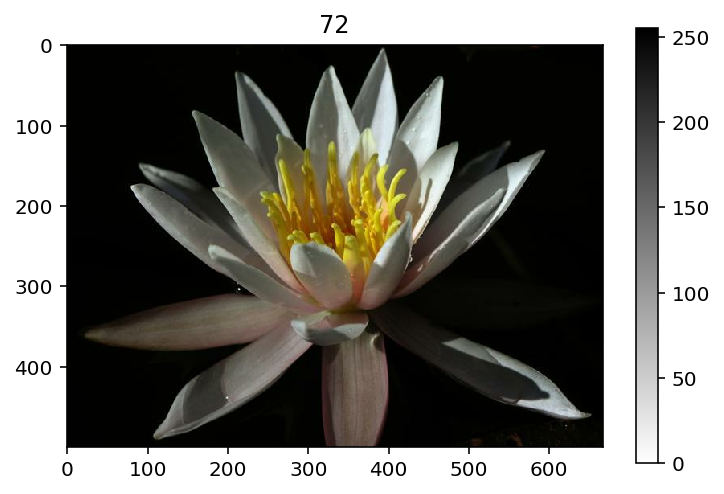

In [5]:
# TODO: Plot 1 image from the training set. 
for img, lbl in train_set.take(1):
    imN = img.numpy().squeeze()
    lblN = lbl.numpy()

plt.imshow(imN, cmap=plt.cm.binary)

# Set the title of the plot to the corresponding image label. 
plt.title(lblN)
plt.colorbar()
plt.show()


### Label Mapping

I'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [6]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

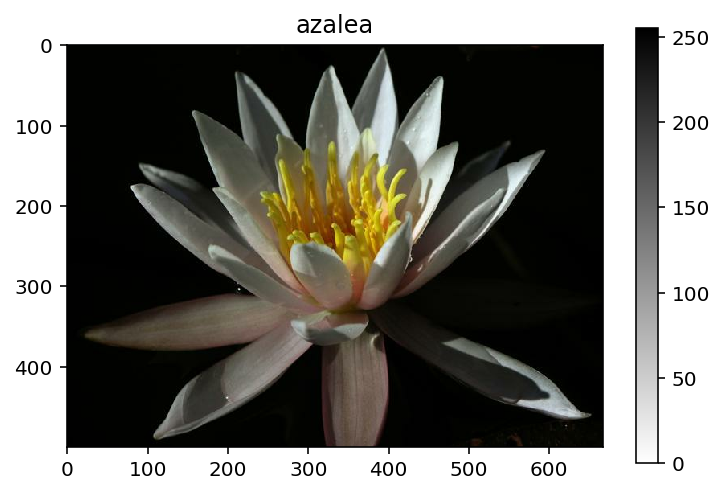

In [7]:
# TODO: Plot 1 image from the training set. Set the title of the plot to the corresponding class name. 
for img, lbl in train_set.take(1):
    imgN = img.numpy().squeeze()
    lblN = lbl.numpy()

plt.imshow(img, cmap= plt.cm.binary)
plt.title(class_names[str(lblN)])
clbl=plt.title(class_names[str(lblN)])
plt.colorbar()
plt.show()



## Create Pipeline

In [8]:
@tf.autograph.experimental.do_not_convert
# TODO: Create a pipeline for each set.
#data preprocessing
def parse_image(img, lbl):
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, [224, 224])
    img=img/200
    return img, lbl

train_batch=train_set.shuffle(training_examples_no//4).map(parse_image).batch(32).prefetch(1)
validation_batch=validation_set.shuffle(validating_examples_no//4).map(parse_image).batch(32).prefetch(1)
test_batch=test_set.shuffle(testing_examples_no//4).map(parse_image).batch(32).prefetch(1)

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. I used the MobileNet pre-trained model from TensorFlow Hub to get the image features then I build and train a new feed-forward classifier using those features.
 
Things I'll need to do:
* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

When training I made sure that I'm updating only the weights of the feed-forward network.

In [9]:
#pretrained model
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL, input_shape=(224, 224,3))
#freeze the parameters
feature_extractor.trainable = False

In [10]:
# TODO: Build and train your network.
model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(classes_no, activation = 'softmax')
])

model.summary()


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#introducing regularization method (Early Stopping)
early_stopping=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
hist = model.fit(train_batch,epochs=5,validation_data=validation_batch,callbacks=[early_stopping])



Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 102)               130662    
                                                                 
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOS

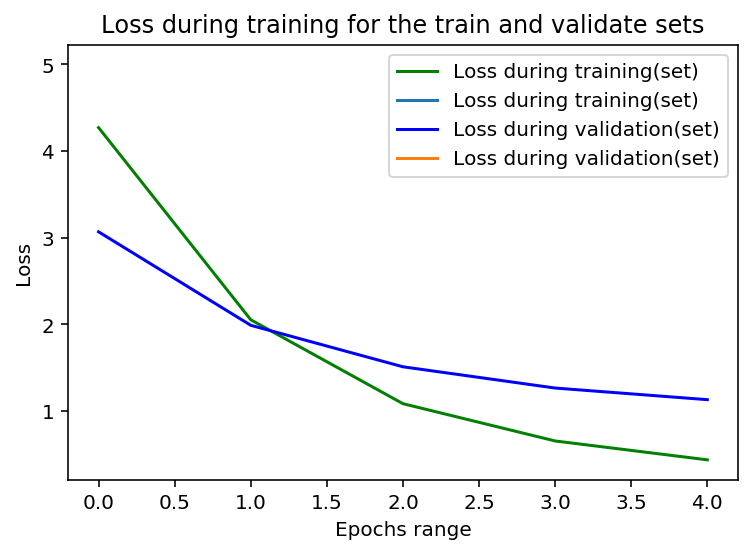

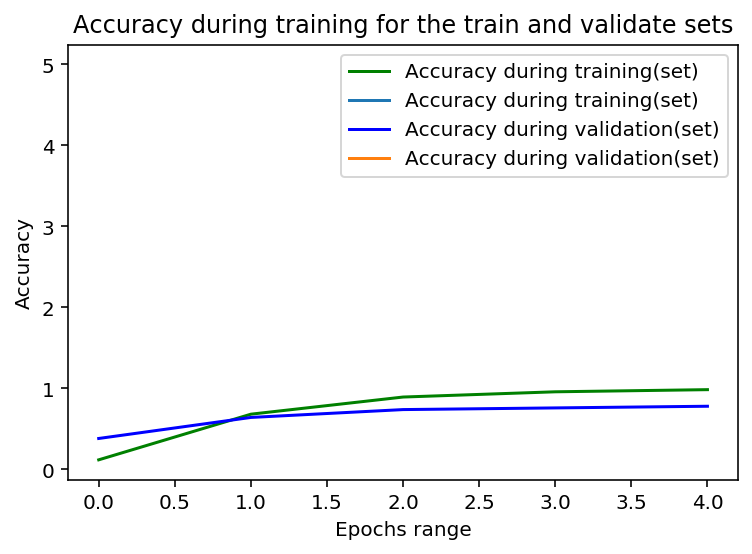

In [11]:
# TODO: Plot the loss and accuracy values achieved during training for the training and validation set.
train_loss=hist.history['loss']
validate_loss=hist.history['val_loss']
epochs=5
#plotting for the loss values
plt.plot(train_loss,'g',epochs,label='Loss during training(set)')
plt.plot(validate_loss,'b',epochs,label='Loss during validation(set)')

plt.xlabel('Epochs range')
plt.ylabel('Loss')
plt.title('Loss during training for the train and validate sets')
plt.legend()
plt.show()

#for the accuracy values
train_accuracy=hist.history['accuracy']
validate_accuracy=hist.history['val_accuracy']
epochs=5
#plotting for the loss values
plt.plot(train_accuracy,'g',epochs,label='Accuracy during training(set)')
plt.plot(validate_accuracy,'b',epochs,label='Accuracy during validation(set)')

plt.xlabel('Epochs range')
plt.ylabel('Accuracy')
plt.title('Accuracy during training for the train and validate sets')
plt.legend()
plt.show()

## Testing the Network

It's good practice to test the trained network on test data, images the network has never seen either in training or validation. This will give one a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [12]:
# TODO: Print the loss and accuracy values achieved on the entire test set.
loss, accuracy = model.evaluate(test_batch)
print('loss on the entire test set: {:,.3f}'.format(loss))
print('accuracy on the entire test set: {:.3%}'.format(accuracy))


193/193 [==============================] - 230s 1s/step - loss: 1.2598 - accuracy: 0.7463
loss on the entire test set: 1.260
accuracy on the entire test set: 74.630%


# Save the Model

Now that the network is trained, save the model so as to load it later for making inference. In the cell below, I saved the model as a Keras model (*i.e.* saved it as an HDF5 file).

In [13]:
# TODO: Save your trained model as a Keras model.
import time
tm=time.time()
mdl_fp='./dl_model.h5'.format(int(tm))
model.save(mdl_fp)

#confirm save
print('Model successfully saved.')

Model successfully saved.


## Load the Keras Model

Load the Keras model you saved above.

In [14]:
# TODO: Load the Keras model
loaded_model=tf.keras.models.load_model(mdl_fp,custom_objects={'KerasLayer':hub.KerasLayer})
#confirm laod
print('Model successfully loaded.')


Model successfully loaded.


# Inference for Classification

Now I'll write a function that uses the trained network for inference. 

The `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. I recommend writing a separate function called `process_image` that performs the pre-processing. I can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, I should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, I'll also need to normalize the pixel values. 

Finally, convert the image back to a NumPy array using the `.numpy()` method.

In [15]:
# TODO: Create the process_image function
def process_image(img):
    img=tf.convert_to_tensor(img, dtype=tf.float32)
    img = tf.image.resize(img, [224, 224])
    img/=255.0
    return img.numpy()


To check the `process_image` function 4 images have been provided in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by the `process_image` function. If the `process_image` function works, the plotted image should be the correct size. 

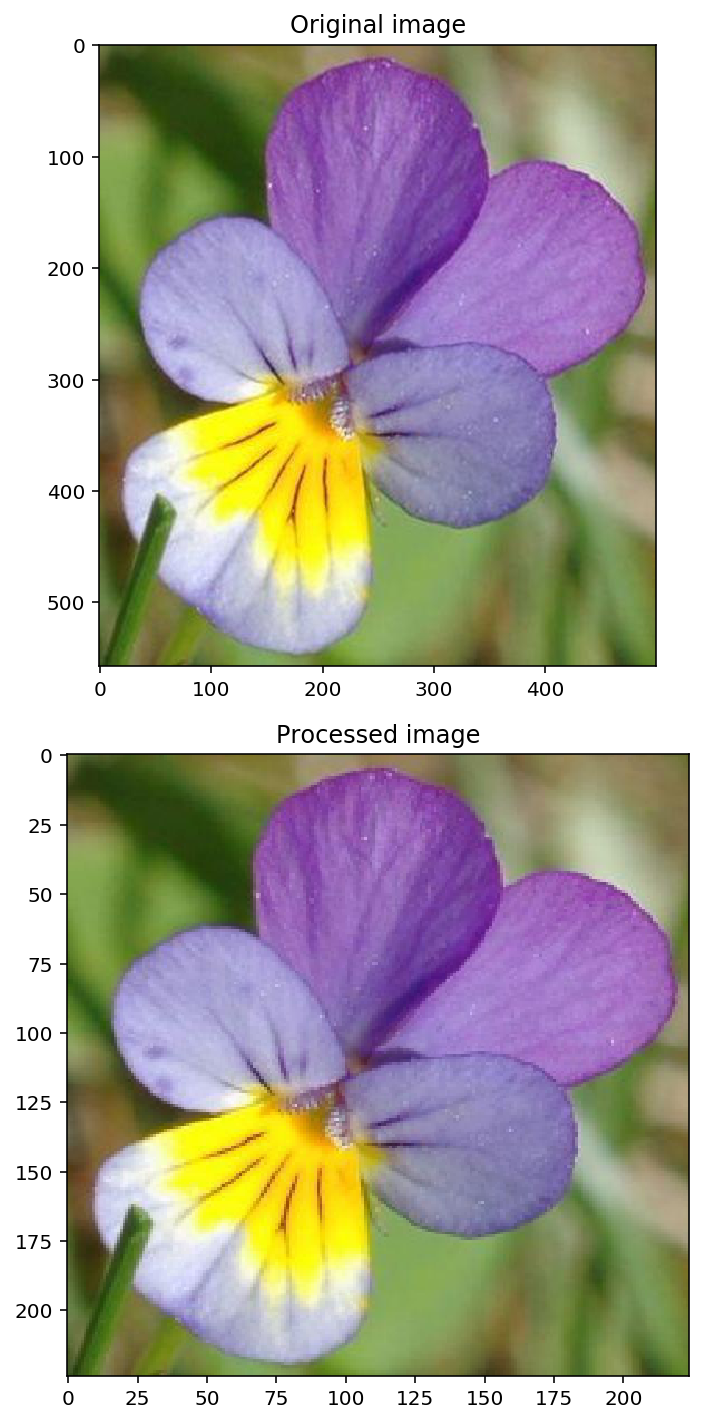

In [16]:
from PIL import Image

image_path = './test_images/wild_pansy.jpg'
img = Image.open(image_path)
test_img = np.asarray(img)

pr_img = process_image(test_img)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), nrows=2)
ax1.imshow(test_img)
ax1.set_title('Original image')
ax2.imshow(pr_img)
ax2.set_title('Processed image')
plt.tight_layout()
plt.show()

Once I can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities.

The `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. The suggestion is to use the `np.expand_dims()` function to add the extra dimension. 

In [17]:
# TODO: Create the predict function
from PIL import Image
def predict(img_pt,mdl,t_k):
    '''
    function predict takes an image from an image path
    takes a model
    and returns the top k most likely labels and
    the correct probabilities
    '''
    img=Image.open(img_pt)
    img=np.asarray(img)
    #pass the image to the process image function
    img=process_image(img)
    #dimension adjustment to cater for the batch size
    dim_adj=np.expand_dims(img,axis=0)
    #takes a model
    proba=loaded_model.predict(dim_adj)
    #part for the returning the top k most likely label and probability
    cls,t_k=tf.nn.top_k(proba,t_k)
    
    #change the label and probability to a Numpy array
    t_k=t_k.numpy()
    cls=cls.numpy()
    
    return cls,t_k

# Sanity Check

It's always good to check the predictions made by the model to make sure they are correct. To check the predictions  4 images are thereby provided in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg
 

1/1 [==============================] - 0s 44ms/step
classes [[51 63 33 18 81]]
Probability [[0.9295391  0.00729761 0.00670158 0.00648923 0.0049109 ]]
wild pansy
silverbush
mexican aster
balloon flower
clematis


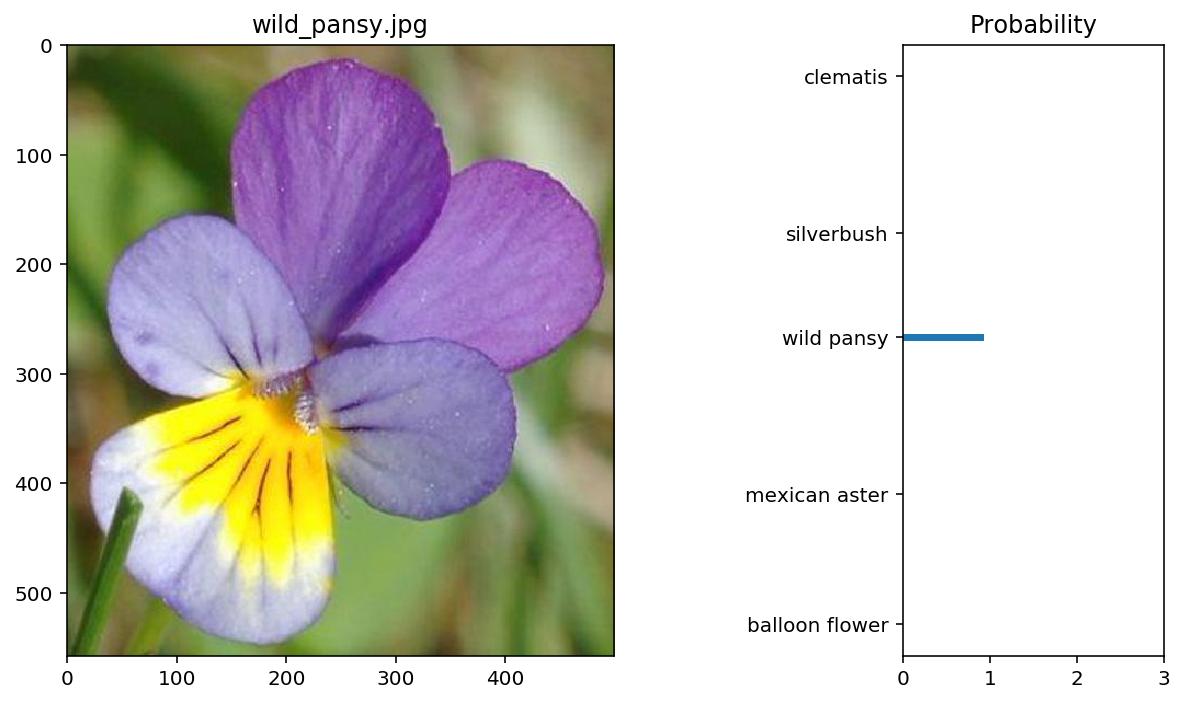

In [27]:
# TODO: Plot the input image along with the top 5 classes
img_pt = './test_images/wild_pansy.jpg'.format(img)
mdl=loaded_model
t_k=5
cls,proba=predict(img_pt,mdl,t_k)
print('classes',proba)
print('Probability',cls)

#adjusting the class label numbering because of label mapping from JSON
cls_num=[]
for i in proba[0]:
    cls_num.append(class_names[str(i+1)])
    print(class_names[str(i+1)])

fig, (ax1, ax2) = plt.subplots(figsize=(10,5), ncols=2)
ax1.imshow(img)
ax1.set_title('wild_pansy.jpg')
ax2.barh(proba[0],cls[0])
ax2.set_aspect(0.1)
ax2.set_yticks(proba[0])
ax2.set_yticklabels(cls_num);
ax2.set_title('Probability')
ax2.set_xlim(0,3.0)
plt.tight_layout()
plt.show()